In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

# Open Traffic Reporter Validation Service 

### 1. Generate Random Routes

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')

In [3]:
routeList = val.get_routes_by_length('San Francisco', 1, 5, 20, mapzenKey)

### 2. Iterate Through Routes and Score the Matches

In [4]:
df = pd.DataFrame(columns=[
    'route','noise','sample_rate','score','avg_density', 'route_url','trace_attr_url','reporter_url'])
outDfRow = -1
saveResults = True

for i, rteCoords in enumerate(routeList):
    stName = rteCoords[0].keys()[0].encode("ascii", "ignore")
    endName = rteCoords[1].keys()[0].encode("ascii", "ignore")
    stLat = rteCoords[0].values()[0]["lat"]
    stLon = rteCoords[0].values()[0]["lon"]
    endLat = rteCoords[1].values()[0]["lat"]
    endLon = rteCoords[1].values()[0]["lon"]
    shape, routeUrl = val.get_route_shape(stLat, stLon, endLat, endLon)
    if shape is None:
        print routeUrl
        continue
    edges, traceAttrUrl = val.get_trace_attrs(shape, "map_snap")
    edges = val.get_coords_per_second(shape, edges, '2768')
    avgDensity = np.mean([edge['density'] for edge in edges])
    noiseLevels = np.linspace(0, 100, 21)
    sampleRates = [1, 5, 10, 20, 30]
    scores = []
    
    for noise in noiseLevels:
        noise = round(noise,3)
        routeName = '{0}_to_{1}'.format(stName, endName)
        
        for sampleRate in sampleRates:
            print("Route: {0} // Noise Level: {1} // Sample Rate: {2}".format(
                i, noise, sampleRate))
            Hz = round(1 / sampleRate, 3)
            outDfRow += 1
            df.loc[
                outDfRow, 
                ['route', 'noise','sample_rate','route_url','trace_attr_url']
            ] = [routeName, noise, sampleRate, routeUrl, traceAttrUrl]
            dfEdges = val.format_edge_df(edges)
            if dfEdges['num_segments'].max() > 1:
                break
            dfEdges, jsonDict, geojson = val.synthesize_gps(dfEdges, shape, '2768', noise=noise, sampleRate=sampleRate)
            if jsonDict is None or geojson is None:
                msg = "Trace attributes tried to call more edges than are present in the route shape".format(
                routeName)
                df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
                continue
            segments, reportUrl = val.get_reporter_segments(jsonDict)
            if segments is None:
                continue
            elif segments == 0:
                msg = 'Reporter found 0 segments.'
                df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
                continue
            matches, score = val.get_matches(segments, dfEdges)
            df.loc[outDfRow, ['score', 'reporter_url']] = [score, reportUrl]
            df.loc[outDfRow, 'avg_density'] = avgDensity
            if saveResults:
                matches.to_csv(
                    '../data/matches_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.csv'.format(
                        stName, endName, str(noise), str(Hz)), index=False)
                with open('../data/trace_{0}_to_{1}_w_{2}_m_noise_at_{3}_Hz.geojson'.format(
                    stName, endName, str(noise), str(Hz)), 'w+') as fp:
                    json.dump(geojson, fp)

Route: 0 // Noise Level: 0.0 // Sample Rate: 1
Route: 0 // Noise Level: 0.0 // Sample Rate: 5
Route: 0 // Noise Level: 0.0 // Sample Rate: 10
Route: 0 // Noise Level: 0.0 // Sample Rate: 20
Route: 0 // Noise Level: 0.0 // Sample Rate: 30
Route: 0 // Noise Level: 5.0 // Sample Rate: 1
Route: 0 // Noise Level: 5.0 // Sample Rate: 5
Route: 0 // Noise Level: 5.0 // Sample Rate: 10
Route: 0 // Noise Level: 5.0 // Sample Rate: 20
Route: 0 // Noise Level: 5.0 // Sample Rate: 30
Route: 0 // Noise Level: 10.0 // Sample Rate: 1
Route: 0 // Noise Level: 10.0 // Sample Rate: 5
Route: 0 // Noise Level: 10.0 // Sample Rate: 10
Route: 0 // Noise Level: 10.0 // Sample Rate: 20
Route: 0 // Noise Level: 10.0 // Sample Rate: 30
Route: 0 // Noise Level: 15.0 // Sample Rate: 1
Route: 0 // Noise Level: 15.0 // Sample Rate: 5
Route: 0 // Noise Level: 15.0 // Sample Rate: 10
Route: 0 // Noise Level: 15.0 // Sample Rate: 20
Route: 0 // Noise Level: 15.0 // Sample Rate: 30
Route: 0 // Noise Level: 20.0 // Sampl

### 3. Plot the Scores

In [5]:
df['score'] = df['score'].astype(float)
df['avg_density'] = df['avg_density'].astype(float)
df['noise'] = df['noise'].astype(float)
df['sample_rate'] = df['sample_rate'].astype(float)
df['score_density'] = df['score'] * df['avg_density']

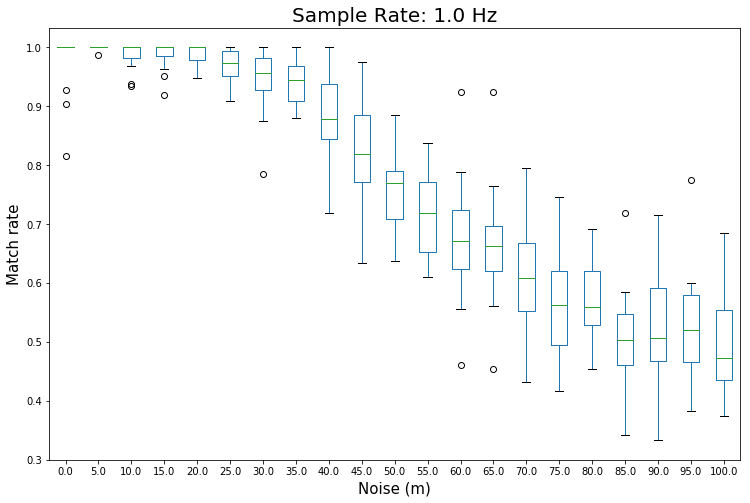

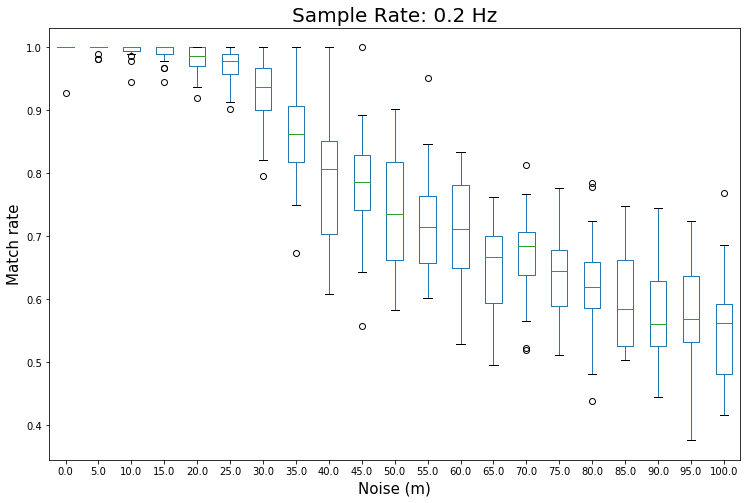

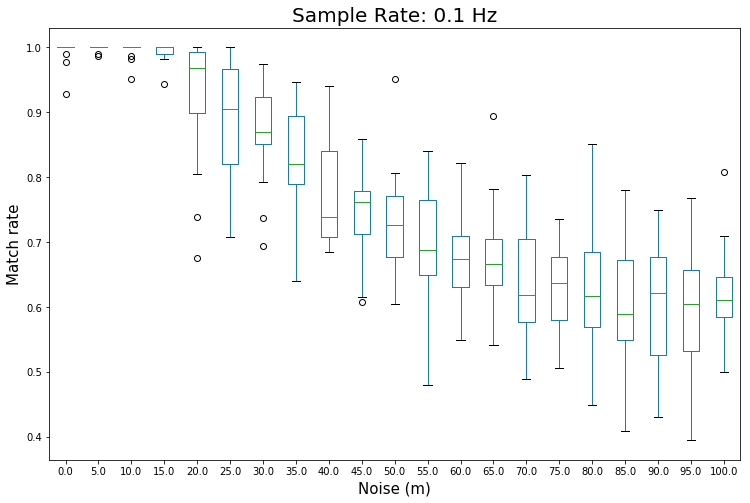

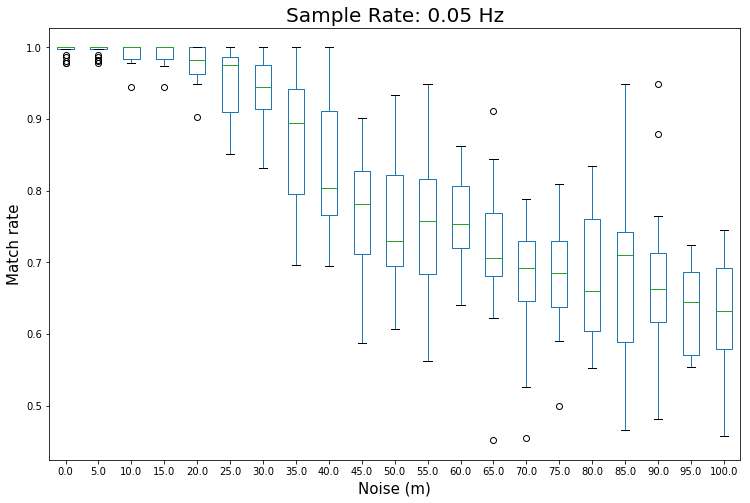

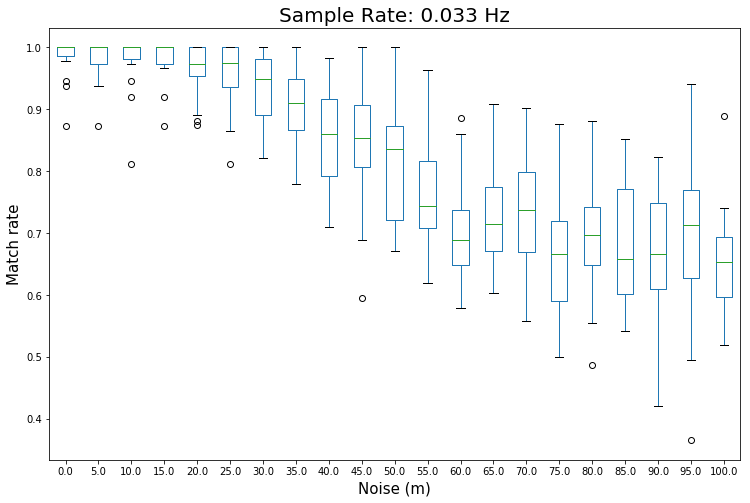

In [6]:
for rate in sampleRates:
    Hz = round(1 / rate, 3)
    fig, ax = plt.subplots(figsize=(12,8))
    df[df['sample_rate'] == rate].boxplot(column='score',by='noise', ax=ax, grid=False)
    ax.set_xlabel('Noise (m)', fontsize=15)
    ax.set_ylabel('Match rate', fontsize=15)
    ax.set_title('Sample Rate: {0} Hz'.format(Hz), fontsize=20)
    fig.suptitle('')
    fig.savefig('./../data/score_vs_noise_{0}_Hz.png'.format(Hz))

In [7]:
data = df[['noise','score','sample_rate']].groupby(['sample_rate','noise']).agg('mean').reset_index()

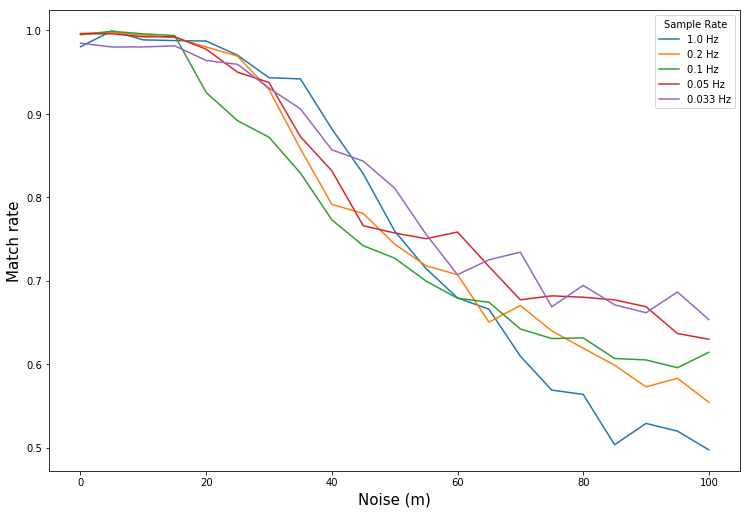

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
for rate in sampleRates:
    ax.plot(data.loc[data['sample_rate'] == rate, 'noise'],
            data.loc[data['sample_rate'] == rate, 'score'],
           label=str(round(1 / rate, 3)) + ' Hz')
ax.legend(title='Sample Rate')
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match rate', fontsize=15)
fig.savefig('../data/score_vs_noise_by_sample_rate.png')

### 4. Visualize Routes

In [39]:
routeList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(routeList)
val.generate_route_map(fname, 14)

In [40]:
fname

'../data/trace_Shop Feng Shui Inc_to_Purple Heart_w_65.0_m_noise_at_0.2_Hz.geojson'

In [36]:
routeList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(routeList)
val.generate_route_map(fname, 14)

In [30]:
routeList = [trace for trace in os.listdir('../data/') if trace.endswith('json')]
fname = '../data/' + choice(routeList)
val.generate_route_map(fname, 14)

In [31]:
fname

'../data/trace_Paul Vuong Insurance Agency_to_Purple Heart_w_100.0_m_noise_at_1.0_Hz.geojson'

### 5. Save the Scores to Master File

In [83]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [84]:
df.to_csv('../data/master_scores.csv', index=False)